In [1]:
!pip3 install torch torchvision torchaudio
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 163 kB 39.2 MB/s 
     |████████████████████████████████| 7.6 MB 29.9 MB/s 


In [2]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [50]:
import json

with open('alzheimer_output1.json', 'r') as f:
  data_alzheimer = json.load(f)
with open('cancer_output1.json', 'r') as f:
  data_cancer = json.load(f)

In [51]:
def Merge(dict1, dict2):
    for i in dict2.keys():
        dict1[i]=dict2[i]
    return dict1
data = Merge(data_alzheimer, data_cancer)

In [53]:
import tqdm

# we can use a persistent dictionary (via shelve) so we can stop and restart if needed
# alternatively, do the same but with embeddings starting as an empty dictionary
embeddings = {}
for pmid, paper in tqdm.tqdm(data.items()):
    data1 = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
    inputs = tokenizer(
        data1, padding=True, truncation=True, return_tensors="pt", max_length=512
    )
    result = model(**inputs)
    # take the first token in the batch as the embedding
    embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]


100%|██████████| 2000/2000 [36:38<00:00,  1.10s/it]


In [54]:
embeddings = [embeddings[pmid] for pmid in data.keys()]

In [55]:
# store the embeddings dictionary into a file to visualize it
with open('embeddings.txt', 'w') as filehandle:
    for i in embeddings:
        filehandle.write(f'{i}\n')

In [56]:
from sklearn import decomposition
import pandas as pd

pca = decomposition.PCA(n_components=3)
embeddings_pca = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca["query"] = [paper["query"] for paper in data.values()]
embeddings_pca.to_csv("embeddings_pca.csv")


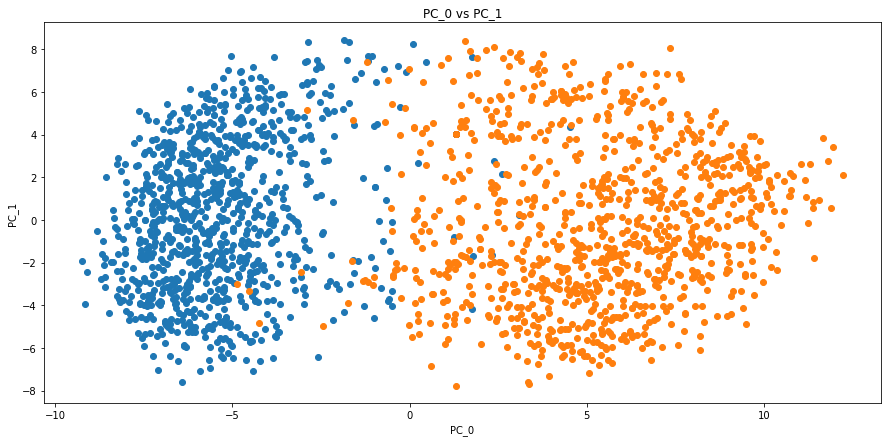

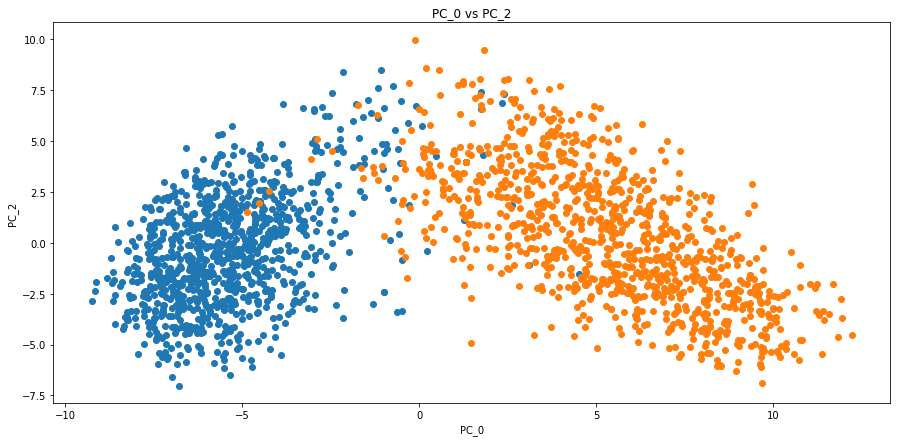

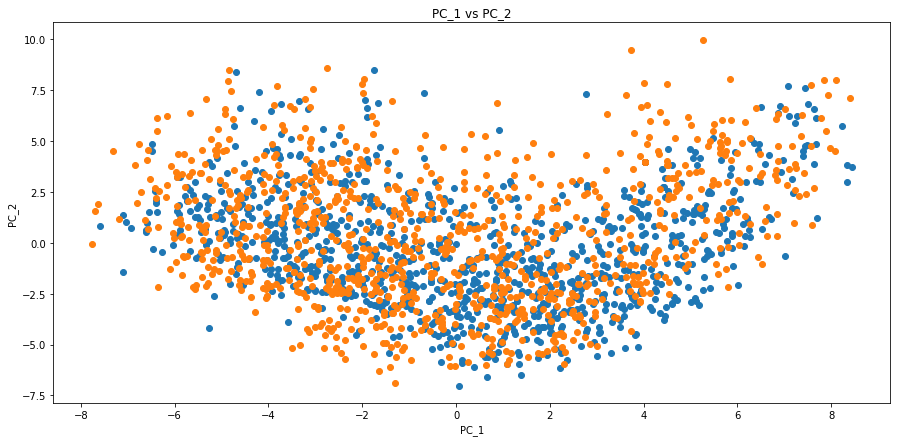

In [57]:
import matplotlib.pyplot as plt
import pandas as pd 

# for alzheimer
pca0_al = embeddings_pca.iloc[0:1000, 0].to_list()
pca1_al = embeddings_pca.iloc[0:1000, 1].to_list()
pca2_al = embeddings_pca.iloc[0:1000, 2].to_list()
# for cancer
pca0_ca = embeddings_pca.iloc[1000:2000, 0].to_list()
pca1_ca = embeddings_pca.iloc[1000:2000, 1].to_list()
pca2_ca = embeddings_pca.iloc[1000:2000, 2].to_list()

plt.figure(figsize=(15,7))
plt.scatter(pca0_al, pca1_al)
plt.scatter(pca0_ca, pca1_ca)
plt.title("PC_0 vs PC_1")
plt.xlabel("PC_0")
plt.ylabel("PC_1")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(pca0_al, pca2_al)
plt.scatter(pca0_ca, pca2_ca)
plt.title("PC_0 vs PC_2")
plt.xlabel("PC_0")
plt.ylabel("PC_2")
plt.show()

plt.figure(figsize=(15,7))
plt.scatter(pca1_al, pca2_al)
plt.scatter(pca1_ca, pca2_ca)
plt.title("PC_1 vs PC_2")
plt.xlabel("PC_1")
plt.ylabel("PC_2")
plt.show()
